<a href="https://colab.research.google.com/github/RomainViardLille/formation_deeplearning/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [35]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


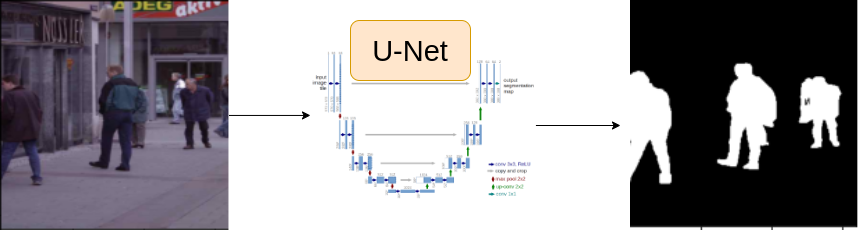

# Some Common Imports

In [36]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [37]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [38]:
# prompt: create variable with csv file of content (os.path.join)

import os
csv_file = os.path.join('/content/Human-Segmentation-Dataset-master','train.csv')

DEVICE='cuda'
EPOCHS=25
LR=0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER ='time-zfficientnet-b0'
WEIGHTS='imagenet'

NUM_WORKERS=2
PIN_MEMORY=True
LOAD_MODEL=False


In [39]:
df=pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [212]:
row=df.iloc[0]
image_path=row.images
mask_path=row.masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
print(f"Image Shape : {image.shape}")
print(f"Mask Shape : {mask.shape}")

Image Shape : (183, 276)
Mask Shape : (183, 276)


In [213]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=41)

In [214]:
def show_image(image,mask):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

  ax1.set_title('IMAGE')
  ax1.imshow(image)

  ax2.set_title('GROUND TRUTH')
  ax2.imshow(mask,cmap = 'gray')

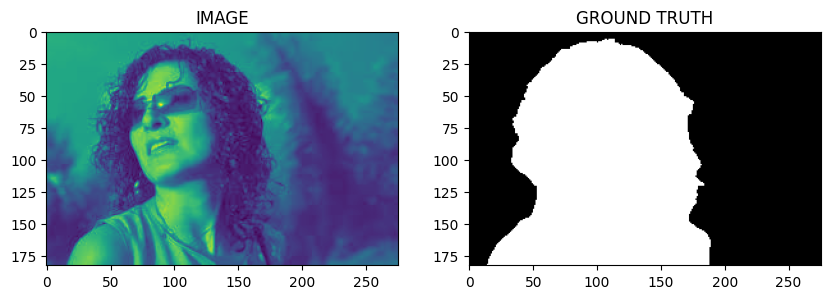

In [215]:
show_image(image,mask)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [216]:
import albumentations as A

In [217]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [218]:
from torch.utils.data import Dataset
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    #print(row)
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #(h,w,c)
    #mask=np.expand_dims(mask,axis=-1)
    print(f"0: {image.shape} : {image_path} \n")
    print(f"0: {mask.shape} : {mask_path} \n")

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

    #image=np.transpose(image,(2,0,1)).astype(np.float32)
    #mask=np.expand_dims(mask,axis=-1)
    #mask=np.transpose(mask,(2,0,1)).astype(np.float32)

    print(f"Image Shape 1: {image.shape}")
    print(f"Mask Shape 1: {mask.shape}")

    image=torch.tensor(image) / 255.0
    mask=torch.round(torch.tensor(mask) / 255.0)

    print(f"Image Shape 2: {image.shape}")
    print(f"Mask Shape 2: {mask.shape}")

    return image,mask

In [219]:
trainset=SegmentationDataset(train_df,get_train_augs())
validset=SegmentationDataset(valid_df,get_valid_augs())

In [220]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


# Task 5 : Load dataset into batches

In [221]:
from torch.utils.data import DataLoader

In [222]:
trainloader=DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True
)
validloader=DataLoader(
    validset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False
)

In [223]:
for image,mask in trainloader:
    print(f"Image batch shape : {image.shape} \n")


0: (640, 480) : Human-Segmentation-Dataset-master/Training_Images/234.jpg 

0: (577, 433) : Human-Segmentation-Dataset-master/Ground_Truth/234.png 

0: (966, 724) : Human-Segmentation-Dataset-master/Training_Images/71.jpg 
0: (640, 480) : Human-Segmentation-Dataset-master/Training_Images/197.jpg 

0: (578, 433) : Human-Segmentation-Dataset-master/Ground_Truth/71.png 


0: (577, 433) : Human-Segmentation-Dataset-master/Ground_Truth/197.png 
0: (667, 1000) : Human-Segmentation-Dataset-master/Training_Images/92.jpg 

0: (408, 612) : Human-Segmentation-Dataset-master/Ground_Truth/92.png 


0: (480, 640) : Human-Segmentation-Dataset-master/Training_Images/159.jpg 

0: (433, 577) : Human-Segmentation-Dataset-master/Ground_Truth/159.png 



ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-218-214d8df3f703>", line 25, in __getitem__
    data=self.augmentations(image=image,mask=mask)
  File "/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py", line 304, in __call__
    self.preprocess(data)
  File "/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py", line 333, in preprocess
    self._check_args(**data)
  File "/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py", line 402, in _check_args
    raise ValueError(msg)
ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).


In [155]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 15
Total no. of batches in validloader : 4


In [156]:
for image,mask in validloader:
  print(f"Image batch shape : {image.shape} \n")
  print(f"Mask batch shape : {mask.shape} \n")
  #break

#print(f"Image batch shape : {image.shape}")
#print(f"Mask batch shape : {mask.shape}")

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-149-27fc461f31a7>", line 28, in __getitem__
    image=np.transpose(image,(2,0,1)).astype(np.float32)
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py", line 655, in transpose
    return _wrapfunc(a, 'transpose', axes)
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py", line 59, in _wrapfunc
    return bound(*args, **kwds)
ValueError: axes don't match array


In [78]:
  trainloader

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [79]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


In [80]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name='resnet18',
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

    def forward(self,images,masks=None):

      logits=self.arc(images)
      if masks != None:
        loss1=DiceLoss(mode='binary')(logits,masks)
        loss2=nn.BCEWithLogitsLoss()(logits,masks)
        return logits,loss1+loss2

      return logits

In [81]:
model=SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [82]:
def train_fn(data_loader,model,optimizer):
  model.train()
  total_loss=0.0

  for images,masks in data_loader:
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(deta_loader)

In [83]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss=0.0

  with torch.no.grad():
    for images,masks in data_loader:
      images=images.to(DEVICE)
      masks=masks.to(DEVICE)

      logits,loss=model(images,masks)

      total_loss+=loss.item()

  return total_loss/len(deta_loader)

# Task 8 : Train Model

In [84]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)


In [91]:
trainloader.dataset[0].masks

masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 205, dtype: object


ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).

In [85]:
best_valid_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),'best_model.pt')
    print('Saved Best Model!')

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss}")
  print(f"Valid Loss : {valid_loss}")

masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 39, dtype: object
masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 252, dtype: object
masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 214, dtype: object
masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 6, dtype: object
masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 140, dtype: object
masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 268, dtype: object
masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 130, dt

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-70-b506325fbb8a>", line 23, in __getitem__
    data=self.augmentations(image=image,mask=mask)
  File "/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py", line 304, in __call__
    self.preprocess(data)
  File "/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py", line 333, in preprocess
    self._check_args(**data)
  File "/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py", line 402, in _check_args
    raise ValueError(msg)
ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).


# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya